<a href="https://colab.research.google.com/github/JonathanKolb/MLNNs_project/blob/main/CS401_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS401 Machine Learning and Neural Networks Project
This notebook is a summary of the analysis and modelling I did based on James Leslie's [neural network submission](https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/) to the challenge [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) by authors Jessica Li and Will Cukierski published in 2012 by Kaggle.
In a series of notebooks James Leslie explains his steps to build a neural network to predict the survivors of the Titanic disaster.

Whenever I put sentences in quotation marks (comments in the code will not be highlighted specifically) this means that they were kept from the original notebook. Two examples can be observed in the following:

"**[Part 1](https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation)** of this series dealt with the pre-processing and manipulation of the data. This notebook will make use of the datasets that were created in the first part."



"**[Part 2](https://www.kaggle.com/jamesleslie/titanic-random-forest-grid-search)** covered the use of a random forest for tackling this challenge." 

**[Part 3](https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook)** was the basis for this notebook. As a starting point I copied the solution and the data and let it run. 


First the required packages and the data are loaded. Then the data is prepared for the modelling. Building the neural network and performing some optimization steps is the first part of the modelling. The results are then compared to other common classifiers. Lastly the neural network is further expanded by also incorporating the hometown of the passengers as variable and repeating all the previous training steps.

**Table of Contents**

>[CS401 Machine Learning and Neural Networks Project](#scrollTo=3jq6wLfnS5_o)

>[1. Load packages and data](#scrollTo=NbEufoDGTMqH)

>[2. Pre-processing](#scrollTo=--MpK8w_TRoe)

>>[2.1. Encode categorical variables](#scrollTo=dY_SXhKDziPH)

>>[2.2. Scale continuous variables](#scrollTo=zvZPfSHoT3cb)

>>[2.3. Train-test split](#scrollTo=IRmsoNRG7FqN)

>[3. Neural network](#scrollTo=CGgKlm9SUDq0)

>>[3.1. Train-test baseline model](#scrollTo=7C3fRFRhUILg)

>>>[3.1.1. Create neural network model](#scrollTo=l6lToqRJUK5P)

>>>[3.1.2. Train model](#scrollTo=_fXOR-f0URU7)

>>>[3.1.3. Assess results](#scrollTo=g0Yxs278UV08)

>>[3.2. Grid search](#scrollTo=E38PCCVlaCaR)

>>>[3.2.1. Batch size and epochs](#scrollTo=uFWvLEdJ7OtV)

>>>[3.2.2. Optimization algorithm](#scrollTo=CSF1lAaqEPAq)

>>>[3.2.3. Hidden neurons](#scrollTo=YMxcOu7lp6WQ)

>>>[3.2.4. Dropout](#scrollTo=tqUWxJ6nqAnB)

>>[3.3. Make predictions on unlabeled set](#scrollTo=kN6l8ZFaqNAm)

>>[3.4. Output final predictions](#scrollTo=4Qcj66VhqS8M)

>[4. Trial of other classifiers](#scrollTo=Hwjg3UUJVdK6)

>>[4.1. Logistic Regression](#scrollTo=v2_iNytuyLp7)

>>>[4.1.1. Lasso](#scrollTo=0HpdwY4g_RvR)

>>>[4.1.2. Ridge](#scrollTo=8IRP1aGt_TR-)

>>[4.2. Random Forrest](#scrollTo=yIwgxa3pyQXn)

>>[4.3. SVCs](#scrollTo=m8j517wzyVIH)

>>>[4.3.1. Linear SVC](#scrollTo=-maaZzPJA5iL)

>>>[4.3.2. Polynomial SVC](#scrollTo=b8XLFSRaA9W0)

>>>[4.3.3. RBF SVC](#scrollTo=rvjgF7tNBeQp)

>>>[4.3.4. Sigmoid SVC](#scrollTo=yNeXyFmpB4yv)

>>[4.4. Naive Bayes](#scrollTo=NOKpMzIVCDmL)

>[5. Analyse the impact of home country](#scrollTo=37h9gX_5iWXf)

>>[5.1. Data preparation - adding the hometown and home country as variables](#scrollTo=Ear8PW8KiixJ)

>>>[Test the fuzzy name matching](#scrollTo=i0qco8PMgTbM)

>>>[5.1.1. Apply fuzzy name matching to the original data](#scrollTo=SW7YuwOLgZ7p)

>>>[5.1.2. Merge on the fuzzy names](#scrollTo=PjBzY78agfo4)

>>>[5.1.3. Pre-processing](#scrollTo=amCDZJ3wmF-1)

>>>>[Encode categorical variables](#scrollTo=BgSS4G4hm9k_)

>>>>[Scale continuous variables](#scrollTo=s2IgHSVxm9k_)

>>>>[Train-test split](#scrollTo=AkiSN4JCm9lA)

>>[5.2. Train-test baseline model](#scrollTo=2ypEfewpudbt)

>>>[5.2.1. Create neural network model](#scrollTo=uZcOSQkknan-)

>>>[5.2.2. Train model](#scrollTo=0w0UWmeVnan-)

>>>[5.2.3. Assess results](#scrollTo=kAJJdaLBnan_)

>>[5.3. Grid search](#scrollTo=IHbA1fhOnan_)

>>>[5.3.1. Batch size and epochs](#scrollTo=iK1IFdN5nan_)

>>>[5.3.2. Optimization algorithm](#scrollTo=X6rrQup2naoA)

>>>[5.3.3. Hidden neurons](#scrollTo=ZOqwJSd4naoB)

>>>[5.3.4. Dropout](#scrollTo=SLT5vakVnaoB)

>>[5.4. Make predictions on unlabeled set](#scrollTo=zod6r-krV7JK)

>>[5.5. Output final predictions](#scrollTo=POgt9WPTV7JK)

>[6. Conclusion](#scrollTo=dVaO4oi0Q8OD)



<a id="loading"></a>
# 1.&nbsp;Load packages and data
[Back to Top](#scrollTo=3jq6wLfnS5_o)

I used Google Colab as the IDE to program the project in. The main reason is the ease of use. The online IDE takes care of creating the Python environment with numerous preinstalled packages. Thus, there is less effort to be put into keeping Python and all packages running.

To avoid uploading the data everytime I started a runtime, I used Google Drive as a file storage and connected it to the runtime with the following code.

In [1]:
# general packages
import numpy as np
import pandas as pd
import seaborn as sns
import os

# packages for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

# packages for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# packages for neural network
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# packages to set the random seed
from numpy.random import seed
from tensorflow.random import set_seed

# packages for logistic regression
from sklearn.linear_model import LogisticRegression

# packages for random forest
from sklearn.ensemble import RandomForestClassifier

# package for Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# package for SVCs
from sklearn.svm import SVC

For the analysis of the passengers' ethnicities and their possible relation to the chances of survival the respective information must first be provided about the passengers. To match the data from this challenge with an external data sources, fuzzy string matching is used. [This tutorial](https://www.datacamp.com/tutorial/fuzzy-string-python) was used as inspiration for the solution and the `fuzzywuzzy` package was used. The `python-Levenshtein` component is installed to allow for more performant solving of the matching.


In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 2.2 MB 56.0 MB/s 


In [3]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [4]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("./"))

['.config', 'Titanic_Hometown_clean.csv', 'test_clean.csv', 'train_clean.csv', 'sample_data']


The so called ```test_clean.csv``` data is actually the unlabeled data that is to be predicted. In a way it is test data because when it is uploaded to Kaggle as a solution, a score will be calculated.

For my purposes I wanted an unseen test set that I can use in this notebook to verify the optimization of the neural network. So as opposed to the original notebook I read the ```test_clean.csv``` data in as ```unlabeled``` so the destinction is clear. Later on I create my train and test data split purely from the ```train_clean.csv``` data set.

In [5]:
# Load data as Pandas dataframe
train = pd.read_csv('./train_clean.csv')
unlabeled = pd.read_csv('./test_clean.csv')
df = pd.concat([train, unlabeled], axis=0, sort=True)

In [6]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="pre-processing"></a>
# 2.&nbsp;Pre-processing
[Back to Top](#scrollTo=3jq6wLfnS5_o)


In this part the data is prepared for the modeling. While most of the data preparation and feature engineering was done in **[Part 1](https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation)**, there are still some important steps before the model creation. 


<a id="encoding"></a>
## 2.1. Encode categorical variables

"We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are `Embarked`, `Sex` and `Title`."   

"The `Sex` variable can be encoded into single 1-or-0 column, but the other variables will need to be [one-hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not **more** than Embarked = 0 - it's just _different_). One Hot Encoding avoids this problem."

"We will assume that there is some ordinality in the `Pclass` variable, so we will leave that as a single column."

One might argue that the class is more suitable as a categorical variable. For now it is not considered as such.

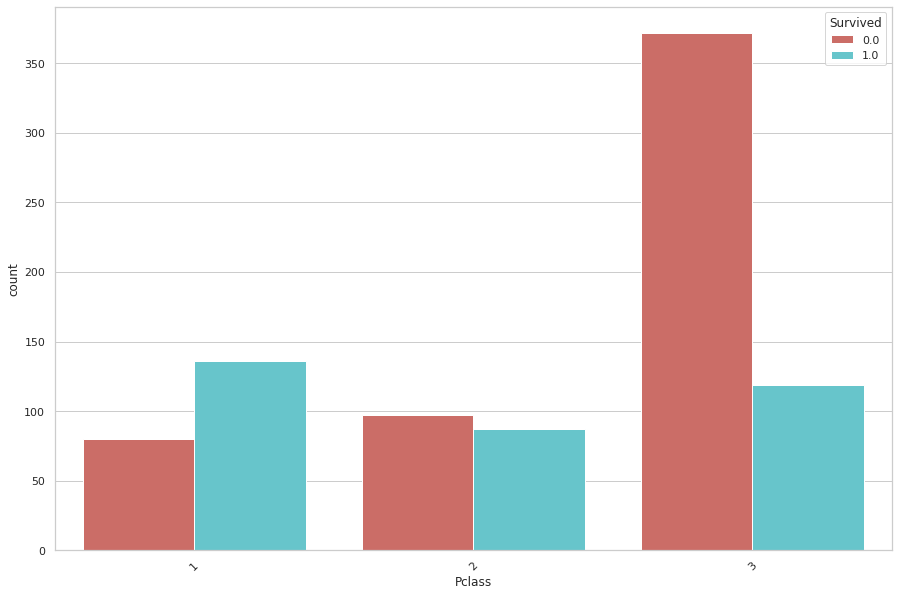

In [8]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

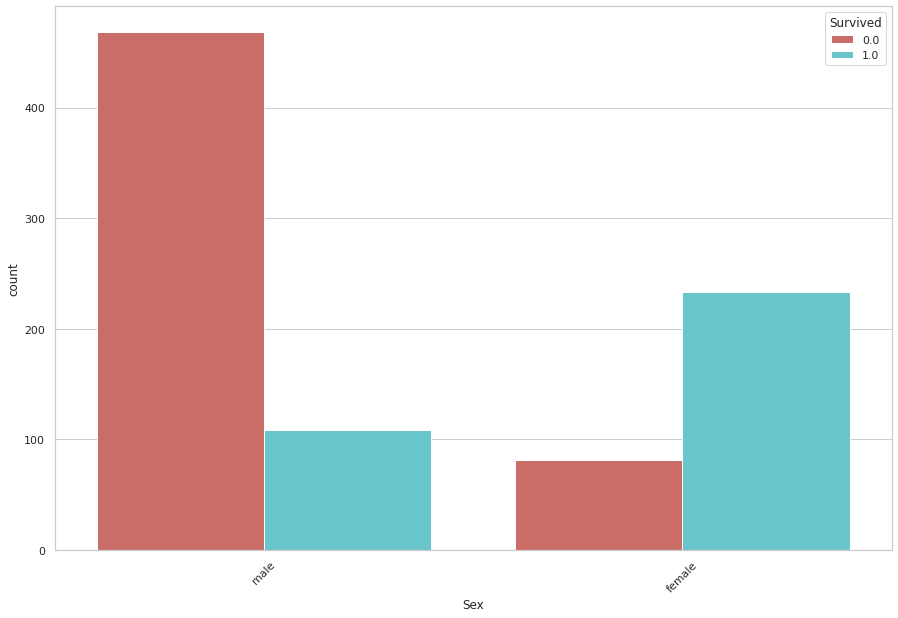

In [9]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

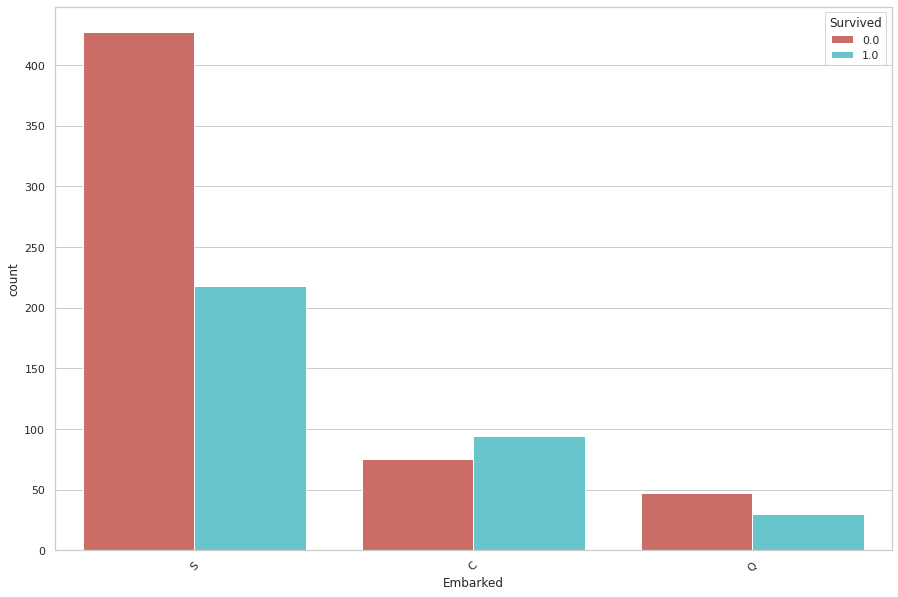

In [10]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [11]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

If one were to consider the class of the passengers as a categorical variable then here would be the place to format the values as such.

In [12]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [13]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [14]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


## 2.2. Scale continuous variables
[Back to Top](#scrollTo=3jq6wLfnS5_o)

"The continuous variables need to be scaled. This is done using a standard scaler from SkLearn."

In [15]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [16]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,7.327981e-17,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,1.628440e-17,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,2.171254e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,1.730218e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-2.062691e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-1.628440e-17,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


## 2.3. Train-test split

"Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network."

"But first, we need to separate [`df`] back into *train* and [`unlabeled`] sets."

In [17]:
train = df[pd.notnull(df['Survived'])]
X_unlabeled = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

Also for the later experiments the training set gets split into train and test set randomly. This allows us to test the predictions on an *unseen* holdout set of the data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['Survived'], axis=1),
    train['Survived'],
    test_size=0.2, random_state=42)

<a id="neural-network"></a>
# 3.&nbsp;Neural network
[Back to Top](#scrollTo=3jq6wLfnS5_o)



## 3.1. Train-test baseline model
[Back to Top](#scrollTo=3jq6wLfnS5_o)

"Keras allows us to make use of cross-validation for training our model."

While this is true, the original notebook does not shuffle the data before each epoch. Thus, there is not cross-validation being used in this section. It will be introduced later and added where it was not used in the original notebook.

The big change compared to the original notebook is the use of the `relu` activation layer when creating models. It generally produced models with higher accuracy and converged faster. 

### 3.1.1. Create neural network model
"For this task, I have kept the model architecture pretty simple. We have one input layer with 17 nodes which feeds into a hidden layer with 8 nodes and an output layer which is used to predict a passenger's survival."   

"The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1."   

"We are going to create a function which allows to parameterise the choice of hyperparameters in the neural network. This might seem a little overly complicated now, but it will come in super handy when we move onto tuning our parameters later."

In [19]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [20]:
model = create_model(act='relu')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None


### 3.1.2. Train model
"At this stage, we have our model. We have chosen a few hyperparameters such as the number of hidden layers, the number of neurons and the activation function."

"The next step is to train the model on our training set. This step also requires us to choose a few more hyperparameters such as the loss function, the optimization algorithm, the number of epochs and the batch size."

Here come the previous train-test split into play. While the original author assumed that the split in fitting the model is random, it is not.
As is specified in the tensorflow keras [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model) the validation_split variable always takes that proportion of the data from the end of the data set. When there is no shuffling then this train-test split will always keep the same for all epochs. Thus, it is not cross-validation hence why there should be a seperate holdout set to validate the results on. This is more relevant when the parameters are optimized on the train-test split of the model and the respective accuracies and losses. When decisions are also made based on the best results for train and test split the seperate holdout set can validate the decisions.

In [21]:
# The commented out line the results from the original notebook using the full dataset.
# training = model.fit(train.drop(['Survived'], axis=1), train['Survived'], epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# The following takes the 80% training data and applies an 80/20 split to it for the first neural network model.
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 77.27%


### 3.1.3. Assess results

First the model is validated on the unseen holdout set.

In [22]:
accuracy_score(y_test, np.round(model.predict(X_test)))

6/6 [==============================] - 0s 4ms/step


0.8268156424581006

The plots of the accuracy by epoch help to assess the results. Comparing the accuracy of the training set and the validation accuracy of the test set helps to guarantee that the model generalises well. To see when the model converges one can look when there is little or no improvement in the accuracy anymore. To see if any overfitting is happening or when it possibly starts the loss and the validation loss were added to the original plot. 

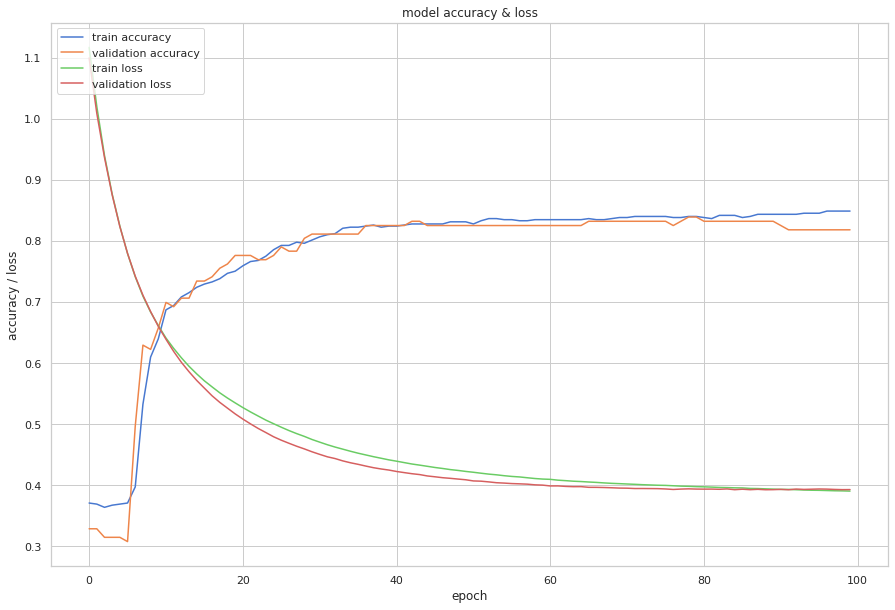

In [23]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy', 'train loss', 'validation loss'], loc='upper left')
plt.show()

## 3.2. Grid search
[Back to Top](#scrollTo=3jq6wLfnS5_o)

This section is concerned with the optimisation of the model arguments. Batch size, number of epochs, number of layers and neurons, and dropout are the parameters that will be searched for. The only change in the following is the introduction of the same 3 fold cross-validation for all parameter optimisations.


### 3.2.1. Batch size and epochs
"We can see from the graph above that we might be training our network for too long. Let's use **grid search** to find out what the optimal values for `batch_size` and `epochs` are."

In this part cross-validation is actually introduced to the modelling of the grid search. This makes overfitting less likely.

In [24]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

<ipython-input-24-39d4cc063c24>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   3.6s
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   3.3s
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   2.8s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   4.8s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   5.0s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   5.8s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   1.9s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   2.0s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   1.8s
[CV] END ................act=relu, batch_size=32, epochs=100; total time=   3.3s
[CV] END ................act=relu, batch_size=32, epochs=100; total time=   3.3s
[CV] END ................act=relu, batch_size=32,

In [25]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.835697 using {'act': 'relu', 'batch_size': 16, 'epochs': 100}
0.827252 (0.012342) with: {'act': 'relu', 'batch_size': 16, 'epochs': 50}
0.835697 (0.020753) with: {'act': 'relu', 'batch_size': 16, 'epochs': 100}
0.818808 (0.015156) with: {'act': 'relu', 'batch_size': 32, 'epochs': 50}
0.830065 (0.012913) with: {'act': 'relu', 'batch_size': 32, 'epochs': 100}
0.783705 (0.008729) with: {'act': 'relu', 'batch_size': 64, 'epochs': 50}
0.824439 (0.015516) with: {'act': 'relu', 'batch_size': 64, 'epochs': 100}


To validate the results, the accuracy is measured on the unseen holdout data set.

In [26]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8324022346368715

### 3.2.2. Optimization algorithm



In [27]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


<ipython-input-27-462a9a647231>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)


[CV] END ..................................act=relu, opt=SGD; total time=   2.0s
[CV] END ..................................act=relu, opt=SGD; total time=   1.7s
[CV] END ..................................act=relu, opt=SGD; total time=   2.0s
[CV] END ..............................act=relu, opt=RMSprop; total time=   2.1s
[CV] END ..............................act=relu, opt=RMSprop; total time=   2.1s
[CV] END ..............................act=relu, opt=RMSprop; total time=   2.1s
[CV] END ..............................act=relu, opt=Adagrad; total time=   2.0s
[CV] END ..............................act=relu, opt=Adagrad; total time=   1.9s
[CV] END ..............................act=relu, opt=Adagrad; total time=   1.9s
[CV] END .............................act=relu, opt=Adadelta; total time=   1.7s
[CV] END .............................act=relu, opt=Adadelta; total time=   1.7s
[CV] END .............................act=relu, opt=Adadelta; total time=   3.2s
[CV] END ...................

The best result has a little worse accuracy than the grid search for batch size and epochs.

In [28]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818808 using {'act': 'relu', 'opt': 'Adam'}
0.745795 (0.004776) with: {'act': 'relu', 'opt': 'SGD'}
0.816007 (0.013979) with: {'act': 'relu', 'opt': 'RMSprop'}
0.355293 (0.022172) with: {'act': 'relu', 'opt': 'Adagrad'}
0.362320 (0.020761) with: {'act': 'relu', 'opt': 'Adadelta'}
0.818808 (0.015156) with: {'act': 'relu', 'opt': 'Adam'}
0.818808 (0.015156) with: {'act': 'relu', 'opt': 'Nadam'}


But the validation on the holdout set seems similarly good or a bit better.

In [29]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8268156424581006

### 3.2.3. Hidden neurons

In [30]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


<ipython-input-30-cb7771ca60ff>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END .................................act=relu, lyrs=[8]; total time=   1.8s
[CV] END .................................act=relu, lyrs=[8]; total time=   2.0s
[CV] END .................................act=relu, lyrs=[8]; total time=   2.0s
[CV] END ................................act=relu, lyrs=[10]; total time=   2.0s
[CV] END ................................act=relu, lyrs=[10]; total time=   1.8s
[CV] END ................................act=relu, lyrs=[10]; total time=   2.0s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   2.4s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   1.9s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   2.0s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   2.0s
[CV] END ...................

In [31]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.837110 using {'act': 'relu', 'lyrs': [10]}
0.818808 (0.015156) with: {'act': 'relu', 'lyrs': [8]}
0.837110 (0.017003) with: {'act': 'relu', 'lyrs': [10]}
0.814606 (0.010342) with: {'act': 'relu', 'lyrs': [10, 5]}
0.828659 (0.010953) with: {'act': 'relu', 'lyrs': [12, 6]}
0.834279 (0.016180) with: {'act': 'relu', 'lyrs': [12, 8, 4]}


In [32]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8212290502793296

### 3.2.4. Dropout

In [33]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops, act=['relu'])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


<ipython-input-33-3e13ae4ccde8>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END ...................................act=relu, dr=0.0; total time=   2.0s
[CV] END ...................................act=relu, dr=0.0; total time=   1.8s
[CV] END ...................................act=relu, dr=0.0; total time=   1.8s
[CV] END ..................................act=relu, dr=0.01; total time=   2.4s
[CV] END ..................................act=relu, dr=0.01; total time=   2.0s
[CV] END ..................................act=relu, dr=0.01; total time=   1.8s
[CV] END ..................................act=relu, dr=0.05; total time=   2.0s
[CV] END ..................................act=relu, dr=0.05; total time=   2.0s
[CV] END ..................................act=relu, dr=0.05; total time=   2.0s
[CV] END ...................................act=relu, dr=0.1; total time=   2.0s
[CV] END ...................................act=relu, dr=0.1; total time=   1.8s
[CV] END ...................................act=relu, dr=0.1; total time=   1.8s
[CV] END ...................

In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818808 using {'act': 'relu', 'dr': 0.0}
0.818808 (0.015156) with: {'act': 'relu', 'dr': 0.0}
0.818808 (0.015156) with: {'act': 'relu', 'dr': 0.01}
0.818808 (0.015156) with: {'act': 'relu', 'dr': 0.05}
0.818808 (0.012109) with: {'act': 'relu', 'dr': 0.1}
0.813200 (0.012135) with: {'act': 'relu', 'dr': 0.2}
0.796357 (0.012890) with: {'act': 'relu', 'dr': 0.5}


In [35]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8268156424581006

Compared to the original notebook, a little more complex layout was chosen. These parameters had the better performance when optimizing them independently. The parameters with the best combination of high accuracy and low standard deviation was chosen. Because it would take to long to grid search for a compination of all those parameters they are just assumed to be working well together. Compared to the original notebook this also yields a higher accuracy for the training set.



In [36]:
# create final model
model = create_model(lyrs=[12, 6], dr=0.1, act='relu')

print(model.summary())

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 12)                204       
                                                                 
 dense_161 (Dense)           (None, 6)                 78        
                                                                 
 dropout_74 (Dropout)        (None, 6)                 0         
                                                                 
 dense_162 (Dense)           (None, 1)                 7         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# train model on 80% of the Original Kaggle data set with an 80/20 train-test split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

23/23 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8441

accuracy: 84.41%


In [38]:
accuracy_score(y_test, np.round(model.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8212290502793296

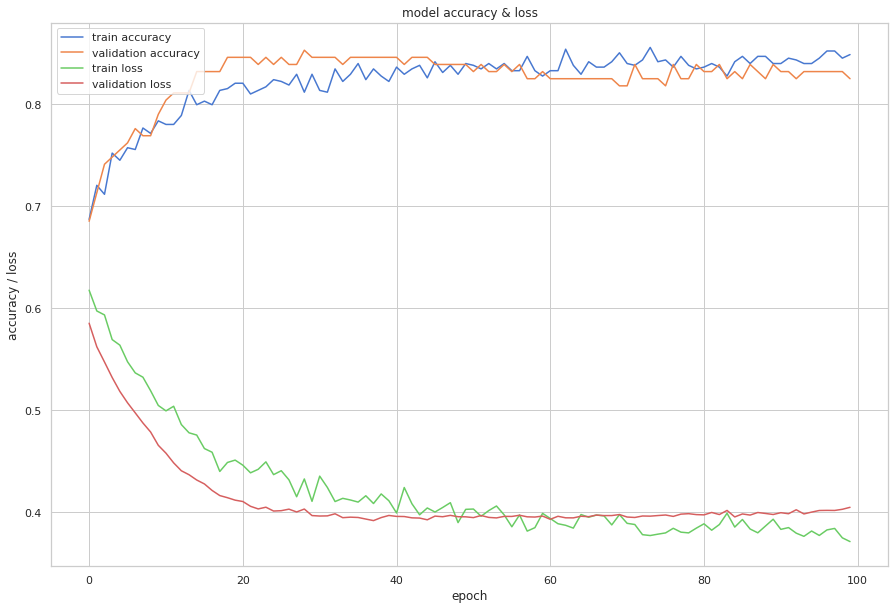

In [39]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy', 'train loss', 'validation loss'], loc='upper left')
plt.show()

## 3.3. Make predictions on unlabeled set
[Back to Top](#scrollTo=3jq6wLfnS5_o)

This section makes the prediction in the form to hand them in as a solution to the Kaggle competition.

In [40]:
# calculate predictions
unlabeled['Survived'] = model.predict(X_unlabeled)
unlabeled['Survived'] = unlabeled['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = unlabeled[['PassengerId', 'Survived']]

14/14 [==============================] - 0s 2ms/step


In [41]:
solution.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


## 3.4. Output final predictions

[Back to Top](#scrollTo=3jq6wLfnS5_o)


In [42]:
solution.to_csv("./Neural_Network_Solution.csv", index=False)

# 4.&nbsp;Trial of other classifiers
[Back to Top](#scrollTo=3jq6wLfnS5_o)



To further evaluate the results of the neural network it is compared to some other popular classifiers.

## 4.1. Logistic Regression
[Back to Top](#scrollTo=3jq6wLfnS5_o)

Define the model:

In [43]:
lr = LogisticRegression(penalty='none', max_iter = 1000)

Fit the model:

In [44]:
seed(42)
set_seed(42)
lr.fit(X_train, y_train)
accuracy_score(y_train, lr.predict(X_train))

0.8328651685393258

Test the fit:

In [45]:
accuracy_score(y_test, lr.predict(X_test))

0.8100558659217877

### 4.1.1. Lasso

In [46]:
lasso = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter = 1000)

In [47]:
seed(42)
set_seed(42)
lasso.fit(X_train, y_train)
accuracy_score(y_train, lasso.predict(X_train))

0.8370786516853933

In [48]:
accuracy_score(y_test, lasso.predict(X_test))

0.8212290502793296

### 4.1.2. Ridge

In [49]:
ridge = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter = 1000)

In [50]:
seed(42)
set_seed(42)
ridge.fit(X_train, y_train)
accuracy_score(y_train, ridge.predict(X_train))

0.8342696629213483

In [51]:
accuracy_score(y_test, ridge.predict(X_test))

0.8156424581005587

## 4.2. Random Forrest
[Back to Top](#scrollTo=3jq6wLfnS5_o)

In [52]:
rf = RandomForestClassifier()

In [53]:
seed(42)
set_seed(42)
rf.fit(X_train, y_train)
accuracy_score(y_train, rf.predict(X_train))

0.9803370786516854

In [54]:
accuracy_score(y_test, rf.predict(X_test))

0.8379888268156425

## 4.3. SVCs
[Back to Top](#scrollTo=3jq6wLfnS5_o)

### 4.3.1. Linear SVC

In [55]:
svc_lin = SVC(kernel='linear')

In [56]:
seed(42)
set_seed(42)
svc_lin.fit(X_train, y_train)
accuracy_score(y_train, svc_lin.predict(X_train))

0.8328651685393258

In [57]:
accuracy_score(y_test, svc_lin.predict(X_test))

0.8212290502793296

### 4.3.2. Polynomial SVC

In [58]:
svc_pol = SVC(kernel='poly', degree=4)

In [59]:
seed(42)
set_seed(42)
svc_pol.fit(X_train, y_train)
accuracy_score(y_train, svc_pol.predict(X_train))

0.8581460674157303

In [60]:
accuracy_score(y_test, svc_pol.predict(X_test))

0.8100558659217877

### 4.3.3. RBF SVC

In [61]:
svc_rbf = SVC(kernel='rbf')

In [62]:
seed(42)
set_seed(42)
svc_rbf.fit(X_train, y_train)
accuracy_score(y_train, svc_rbf.predict(X_train))

0.8441011235955056

In [63]:
accuracy_score(y_test, svc_rbf.predict(X_test))

0.8268156424581006

### 4.3.4. Sigmoid SVC

In [64]:
svc_sig = SVC(kernel='sigmoid')

In [65]:
seed(42)
set_seed(42)
svc_sig.fit(X_train, y_train)
accuracy_score(y_train, svc_lin.predict(X_train))

0.8328651685393258

In [66]:
accuracy_score(y_test, svc_sig.predict(X_test))

0.8044692737430168

## 4.4. Naive Bayes

Naive Bayes is not the best choice as it assumes the variables to have equal impact on the outcome. Also, it does not allow for a mixture of continuous and categorical value. Thus it is mostly as a test to see how a small subset of the variables could predict the results under suboptimal conditions.

Neither of the categorical values model and the continuous values model is comparable in accuracy to the previous models. But the Multinomial Naive Bayes Classifiers is not too far off the other accuracies.

In [67]:
gnb = GaussianNB()

In [68]:
seed(42)
set_seed(42)
gnb.fit(X_train[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']], y_train)
accuracy_score(y_train, gnb.predict(X_train[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']]))

0.6797752808988764

In [69]:
accuracy_score(y_test, gnb.predict(X_test[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']]))

0.7094972067039106

In [70]:
mnb = MultinomialNB()

In [71]:
seed(42)
set_seed(42)
mnb.fit(X_train.drop(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size'], axis=1), y_train)
accuracy_score(y_train, mnb.predict(X_train.drop(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size'], axis=1)))

0.7921348314606742

In [72]:
accuracy_score(y_test, mnb.predict(X_test.drop(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size'], axis=1)))

0.7877094972067039

# 5.&nbsp;Analyse the impact of home country

[Back to Top](#scrollTo=3jq6wLfnS5_o)

One might theorise that the ethnicity of the passengers had a role to play in who got onto one of the too few lifeboats and was thus more likely to survive the disaster. Thus, the predictability of the survival based on the ethnicity would be a topic for analysis.

In the original data set there is no ethnicity included. Consequently, this information would need to be added from an external data source to be included in the modelling. There was no information found readily available on the internet about the ethnicity of passengers. As an alternative the country of the hometown of the passengers was added to the original data set. The information about the passengers' ethnicity was taken from Wikipedia: [List of Passengers of the Titanic](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic#Passenger_list) and [Crew of the Titanic](https://en.wikipedia.org/wiki/Crew_of_the_Titanic).

The most work went into the data preparation. First a combined list of passengers and crew was created to make sure there were matches. Then the information was cleaned using MS Excel, imported as .csv and imported into the environment. Using fuzzy string matching the highest percentage match for each person in the original Kaggle data set was added from the passenger and crew list. Using three iterations of weakening joins the countries of the passengers' hometown were added to the Kaggle data set.

After the hometowns were added, the same steps from data pre-processing to modelling the neural network and the grid search were performed again.

## 5.1. Data preparation - adding the hometown and home country as variables

In [73]:
# Load data as Pandas dataframe
train = pd.read_csv('./train_clean.csv')
unlabeled = pd.read_csv('./test_clean.csv')
df = pd.concat([train, unlabeled], axis=0, sort=True)

In [74]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [75]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Load data as Pandas dataframe
hometowns = pd.read_csv('./Titanic_Hometown_clean.csv', sep=";")
# hometowns.head(20)

### Test the fuzzy name matching

In [77]:
# df.Name.iloc[0]

In [78]:
# highest = process.extractOne(df.Name.iloc[0],hometowns.Name)
# print(highest)

In [79]:
# highest = df.Name.map(lambda x: process.extractOne(x, hometowns.Name))
# print(highest)

In [80]:
# process.extractOne(df.Name.iloc[0],hometowns.Name)[0]

### 5.1.1. Apply fuzzy name matching to the original data

In [81]:
df["fuzzy_name"] = df.Name.map(lambda x: process.extractOne(x, hometowns.Name)[0])

In [82]:
df.to_csv("./titanic_fuzzy_name.csv", index=False)

In [83]:
# hometowns = pd.read_csv('./Titanic_Hometown_clean.csv', sep=";")
# df = pd.read_csv('./titanic_fuzzy_name.csv')

### 5.1.2. Merge on the fuzzy names

Use additional criteria like class and age to validate the fuzzy name match.

In [84]:
df = df.merge(hometowns, left_on=['fuzzy_name','Pclass', 'Age'] , right_on=['Name', 'Class', 'Age'], how='left', indicator=True)

In [85]:
df.to_csv("./titanic_with_hometowns.csv", index=False)

In [86]:
#df = pd.read_csv('../temp/titanic_with_hometowns.csv')

For the ones where no match for fuzzy mame, class, and age could befound, match them only by fuzzy name and class.

In [87]:
temp_df = df[df['_merge']=='left_only'].copy()
temp_df.drop(
    ['Name_y', 'Hometown', 'Country', 'Boarded', 'Destination', 'Lifeboat', 'Body', 'Class', '_merge'],
    axis=1, inplace=True)

In [88]:
temp_right_df = hometowns.copy()
temp_right_df.drop(['Age'],axis=1, inplace=True)
temp_right_df.rename(columns = {'Name':'Name_y'}, inplace = True)

In [89]:
temp_df = temp_df.merge(temp_right_df, left_on=['fuzzy_name','Pclass'] , right_on=['Name_y', 'Class'], how='left', indicator=True)

In [90]:
cols = list(df.columns)
df = df[df['_merge']!='left_only']

In [91]:
df = df.append(temp_df)

For the rows where still no match could be found, only match them by the fuzzy name.

In [92]:
temp_df = df[df['_merge']=='left_only'].copy()
temp_df.drop(
    ['Name_y', 'Hometown', 'Country', 'Boarded', 'Destination', 'Lifeboat', 'Body', 'Class', '_merge'],
    axis=1, inplace=True)

In [93]:
temp_right_df = hometowns.copy()
temp_right_df.drop(['Age'], axis=1, inplace=True)
temp_right_df.rename(columns = {'Name':'Name_y'}, inplace = True)

In [94]:
temp_df = temp_df.merge(temp_right_df, left_on=['fuzzy_name'] , right_on=['Name_y'], how='left', indicator=True)

In [95]:
cols = list(df.columns)
df = df[df['_merge']!='left_only']

In [96]:
df = df.append(temp_df)

In [97]:
df.drop(
    ['fuzzy_name' ,'Name_y', 'Boarded', 'Destination', 'Lifeboat', 'Body', 'Class', '_merge'],
    axis=1, inplace=True)
df.rename(columns = {'Name_x':'Name'}, inplace = True)

Because there were multiple passengers with the name "Kelly, Mr. James" a duplicate for this name was introduced when just matching by name. Because both passengers came from Ireland, the first match is taken and the other gets dropped.

In [98]:
df.shape

(1310, 16)

In [99]:
temp = df[df['PassengerId']==892].iloc[1]

In [100]:
df = df[(df['Name']!=temp['Name']) | (df['PassengerId']!=temp['PassengerId']) | (df['Hometown']!=temp['Hometown'])]

In [101]:
df.shape

(1309, 16)

Display the head of the data frame to check some of the data

In [102]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Hometown,Country
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,Bridgerule,England
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,Jyväskylä,Finland
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,"Scituate, Massachusetts",US
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,Birmingham,England
6,54.0,E46,S,0,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,Mr,"Dorchester, Massachusetts",US


The neural network could not converge when all countries were used for modelling when one-hot encoding their categorical values. Thus only countries that were observed more then 20 times are taken and all other countries are binned together as others. This intruduces some noise into the data. With more time it could have made sense to bin the less observed countries of origin by proximity or some other metric that better explains similarity and differences of them. 

In [103]:
vc = df['Country'].value_counts()

In [104]:
df['Country'] = df['Country'].map(lambda x: 'other' if x not in vc[vc > 20].index else x)

In [105]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.1.3. Pre-processing


#### Encode categorical variables


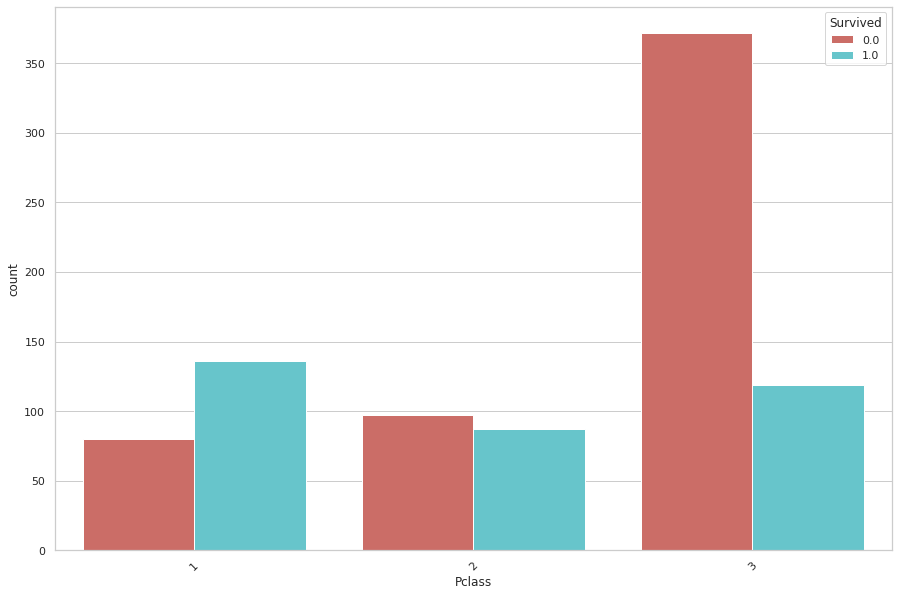

In [106]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

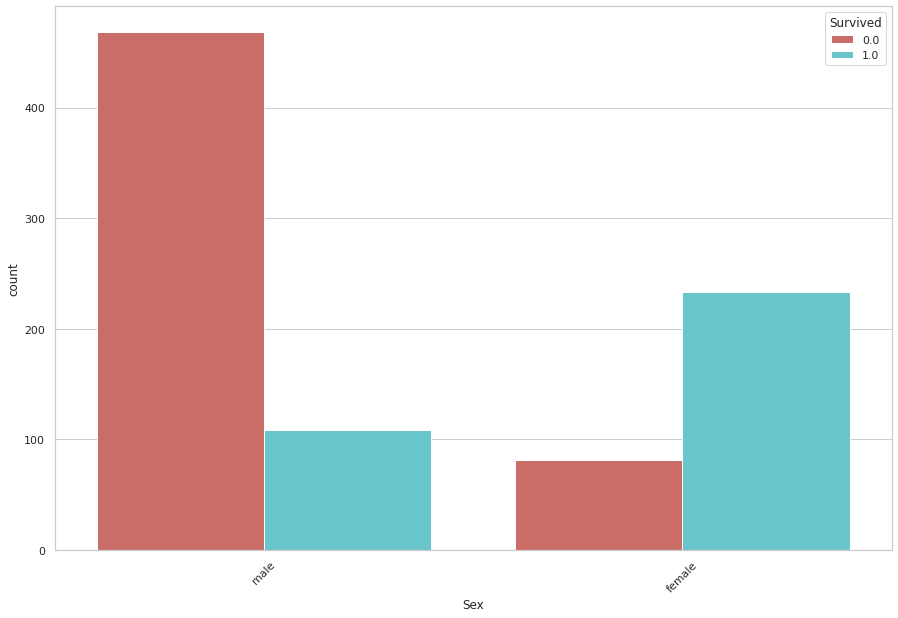

In [107]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

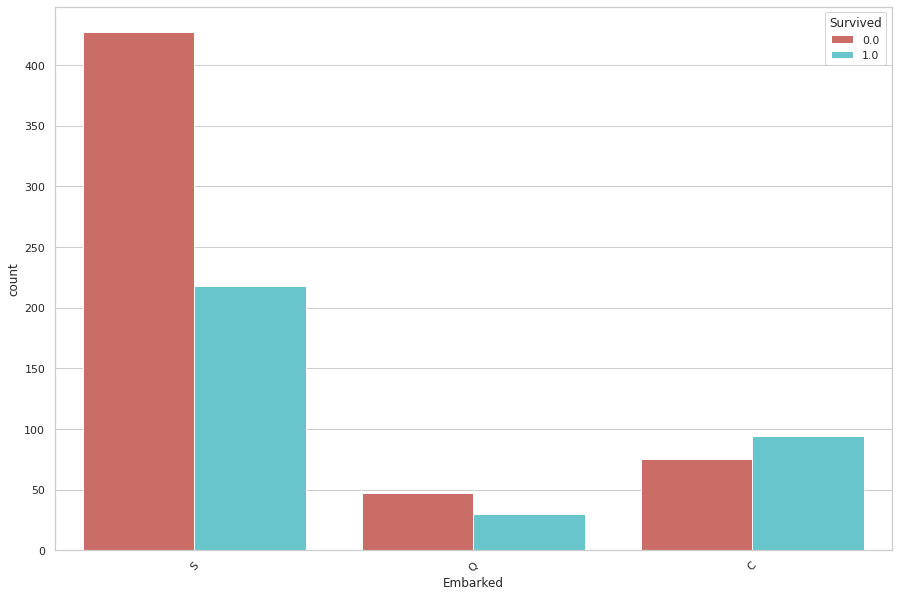

In [108]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

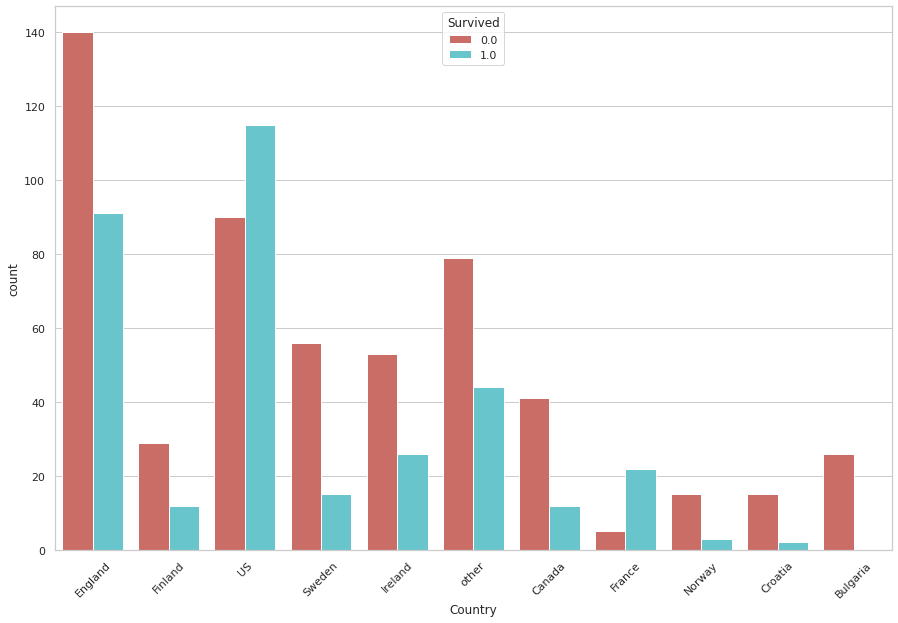

In [109]:
sns.countplot(x='Country', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [110]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [111]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title', 'Country']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [112]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'Hometown'], axis=1, inplace=True)

In [113]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,...,Country_Canada,Country_Croatia,Country_England,Country_Finland,Country_France,Country_Ireland,Country_Norway,Country_Sweden,Country_US,Country_other
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,54.0,0,51.8625,0,1,1,0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Scale continuous variables
[Back to Top](#scrollTo=3jq6wLfnS5_o)

The continuous variables need to be scaled. This is done using a standard scaler from SkLearn.

In [114]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [115]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,7.192278e-17,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,8.142201e-18,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,-1.072056e-16,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,-2.714067e-18,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-2.008410e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,4.342507e-17,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


#### Train-test split

Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network.

But first, we need to separate *data_df* back into *train* and *unlabeled* sets.

In [116]:
train = df[pd.notnull(df['Survived'])]
X_unlabeled = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

Also for the later experiments the training set gets split into train and test set randomly. This allows us to test the predictions on an *unseen* holdout set of the data.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['Survived'], axis=1),
    train['Survived'],
    test_size=0.2, random_state=42)

## 5.2. Train-test baseline model

### 5.2.1. Create neural network model


In [118]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [119]:
model = create_model(act='relu')
print(model.summary())

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_163 (Dense)           (None, 8)                 224       
                                                                 
 dropout_75 (Dropout)        (None, 8)                 0         
                                                                 
 dense_164 (Dense)           (None, 1)                 9         
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None


### 5.2.2. Train model

In [120]:
# The commented out line the results from the original notebook using the full dataset.
# training = model.fit(train.drop(['Survived'], axis=1), train['Survived'], epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# The following takes the 80% training data and applies an 80/20 split to it for the first neural network model.
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 79.97%


### 5.2.3. Assess results

In [121]:
accuracy_score(y_test, np.round(model.predict(X_test)))

6/6 [==============================] - 0s 3ms/step


0.8044692737430168

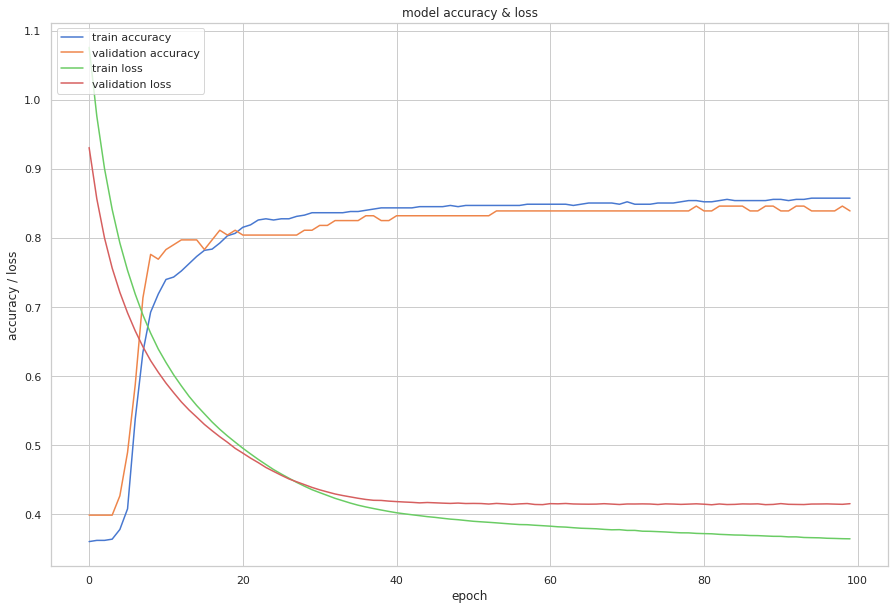

In [122]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy', 'train loss', 'validation loss'], loc='upper left')
plt.show()

## 5.3. Grid search
[Back to Top](#scrollTo=3jq6wLfnS5_o)


### 5.3.1. Batch size and epochs


In [123]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

<ipython-input-123-39d4cc063c24>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   2.9s
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   3.3s
[CV] END .................act=relu, batch_size=16, epochs=50; total time=   2.8s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   4.8s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   5.8s
[CV] END ................act=relu, batch_size=16, epochs=100; total time=   4.8s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   2.0s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   2.1s
[CV] END .................act=relu, batch_size=32, epochs=50; total time=   2.0s
[CV] END ................act=relu, batch_size=32, epochs=100; total time=   3.3s
[CV] END ................act=relu, batch_size=32, epochs=100; total time=   2.9s
[CV] END ................act=relu, batch_size=32,

In [124]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.828677 using {'act': 'relu', 'batch_size': 32, 'epochs': 50}
0.827270 (0.015505) with: {'act': 'relu', 'batch_size': 16, 'epochs': 50}
0.828671 (0.011798) with: {'act': 'relu', 'batch_size': 16, 'epochs': 100}
0.828677 (0.019948) with: {'act': 'relu', 'batch_size': 32, 'epochs': 50}
0.823045 (0.008879) with: {'act': 'relu', 'batch_size': 32, 'epochs': 100}
0.814636 (0.016872) with: {'act': 'relu', 'batch_size': 64, 'epochs': 50}
0.827270 (0.017986) with: {'act': 'relu', 'batch_size': 64, 'epochs': 100}


In [125]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8100558659217877

### 5.3.2. Optimization algorithm



In [126]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


<ipython-input-126-462a9a647231>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)


[CV] END ..................................act=relu, opt=SGD; total time=   1.7s
[CV] END ..................................act=relu, opt=SGD; total time=   2.0s
[CV] END ..................................act=relu, opt=SGD; total time=   1.7s
[CV] END ..............................act=relu, opt=RMSprop; total time=   3.9s
[CV] END ..............................act=relu, opt=RMSprop; total time=   1.9s
[CV] END ..............................act=relu, opt=RMSprop; total time=   2.1s
[CV] END ..............................act=relu, opt=Adagrad; total time=   2.0s
[CV] END ..............................act=relu, opt=Adagrad; total time=   1.9s
[CV] END ..............................act=relu, opt=Adagrad; total time=   1.7s
[CV] END .............................act=relu, opt=Adadelta; total time=   2.0s
[CV] END .............................act=relu, opt=Adadelta; total time=   1.8s
[CV] END .............................act=relu, opt=Adadelta; total time=   3.2s
[CV] END ...................

In [127]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.831478 using {'act': 'relu', 'opt': 'RMSprop'}
0.745807 (0.010547) with: {'act': 'relu', 'opt': 'SGD'}
0.831478 (0.017724) with: {'act': 'relu', 'opt': 'RMSprop'}
0.370806 (0.010956) with: {'act': 'relu', 'opt': 'Adagrad'}
0.367999 (0.011191) with: {'act': 'relu', 'opt': 'Adadelta'}
0.828677 (0.019948) with: {'act': 'relu', 'opt': 'Adam'}
0.828677 (0.019948) with: {'act': 'relu', 'opt': 'Nadam'}


In [128]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8100558659217877

### 5.3.3. Hidden neurons

In [129]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers, act=['relu'])

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


<ipython-input-129-cb7771ca60ff>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END .................................act=relu, lyrs=[8]; total time=   2.1s
[CV] END .................................act=relu, lyrs=[8]; total time=   2.0s
[CV] END .................................act=relu, lyrs=[8]; total time=   1.8s
[CV] END ................................act=relu, lyrs=[10]; total time=   2.0s
[CV] END ................................act=relu, lyrs=[10]; total time=   2.0s
[CV] END ................................act=relu, lyrs=[10]; total time=   2.0s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[10, 5]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   2.1s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   3.8s
[CV] END .............................act=relu, lyrs=[12, 6]; total time=   2.7s
[CV] END ...................

In [130]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.832878 using {'act': 'relu', 'lyrs': [10]}
0.828677 (0.019948) with: {'act': 'relu', 'lyrs': [8]}
0.832878 (0.008391) with: {'act': 'relu', 'lyrs': [10]}
0.820232 (0.004990) with: {'act': 'relu', 'lyrs': [10, 5]}
0.824463 (0.012662) with: {'act': 'relu', 'lyrs': [12, 6]}
0.823074 (0.020548) with: {'act': 'relu', 'lyrs': [12, 8, 4]}


In [131]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8100558659217877

### 5.3.4. Dropout

In [132]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops, act=['relu'])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


<ipython-input-132-3e13ae4ccde8>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


[CV] END ...................................act=relu, dr=0.0; total time=   2.0s
[CV] END ...................................act=relu, dr=0.0; total time=   1.8s
[CV] END ...................................act=relu, dr=0.0; total time=   1.8s
[CV] END ..................................act=relu, dr=0.01; total time=   2.0s
[CV] END ..................................act=relu, dr=0.01; total time=   1.8s
[CV] END ..................................act=relu, dr=0.01; total time=   2.0s
[CV] END ..................................act=relu, dr=0.05; total time=   1.8s
[CV] END ..................................act=relu, dr=0.05; total time=   2.0s
[CV] END ..................................act=relu, dr=0.05; total time=   1.8s
[CV] END ...................................act=relu, dr=0.1; total time=   2.2s
[CV] END ...................................act=relu, dr=0.1; total time=   1.8s
[CV] END ...................................act=relu, dr=0.1; total time=   1.8s
[CV] END ...................

In [133]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.828677 using {'act': 'relu', 'dr': 0.0}
0.828677 (0.019948) with: {'act': 'relu', 'dr': 0.0}
0.828677 (0.019948) with: {'act': 'relu', 'dr': 0.01}
0.827270 (0.017986) with: {'act': 'relu', 'dr': 0.05}
0.825858 (0.015732) with: {'act': 'relu', 'dr': 0.1}
0.827264 (0.014801) with: {'act': 'relu', 'dr': 0.2}
0.813211 (0.019496) with: {'act': 'relu', 'dr': 0.5}


In [134]:
accuracy_score(y_test, np.round(grid.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8100558659217877

The differences between the optimal parameter in each optimisation is only small to the ones chosen when modelling without the country of the hometown. So the same parameters are chosen as before, except for the dropout which was raised to 0.2. This lead to the highest accuracy and improved validation accuracy on the test set.

In [135]:
# create final model
model = create_model(lyrs=[12, 6], dr=0.2, act='relu')

print(model.summary())

Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_323 (Dense)           (None, 12)                336       
                                                                 
 dense_324 (Dense)           (None, 6)                 78        
                                                                 
 dropout_149 (Dropout)       (None, 6)                 0         
                                                                 
 dense_325 (Dense)           (None, 1)                 7         
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
# train model on 80% of the Original Kaggle data set with an 80/20 train-test split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

23/23 [==============================] - 0s 1ms/step - loss: 0.3433 - accuracy: 0.8666

accuracy: 86.66%


In [137]:
accuracy_score(y_test, np.round(model.predict(X_test)))

6/6 [==============================] - 0s 2ms/step


0.8324022346368715

While the accuracy for the model is pretty high there might be some overfitting going on. Especially after epoch 40 the accuracy still increases and training loss decreases while the validation loss increses. 

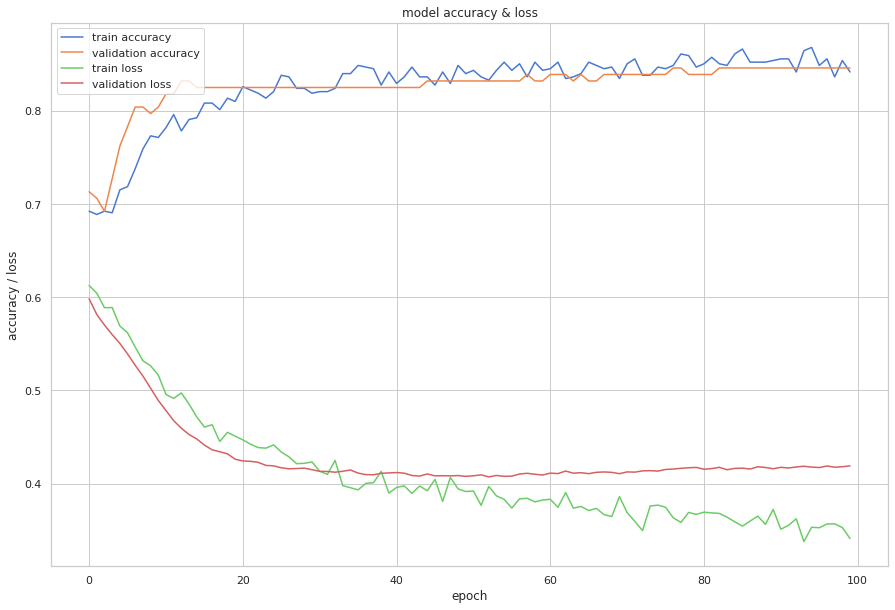

In [138]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy', 'train loss', 'validation loss'], loc='upper left')
plt.show()

## 5.4. Make predictions on unlabeled set
[Back to Top](#scrollTo=3jq6wLfnS5_o)


In [139]:
# calculate predictions
unlabeled['Survived'] = model.predict(X_unlabeled)
unlabeled['Survived'] = unlabeled['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = unlabeled[['PassengerId', 'Survived']]

14/14 [==============================] - 0s 1ms/step


In [140]:
solution.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
5,897,0
6,898,0
7,899,1
8,900,0
9,901,0


## 5.5. Output final predictions

[Back to Top](#scrollTo=3jq6wLfnS5_o)


In [141]:
solution.to_csv("./Neural_Network_Solution_with_Hometown.csv", index=False)

# 6.&nbsp;Conclusion

[Back to Top](#scrollTo=3jq6wLfnS5_o)

Among the models with the best results when considering the combination of training accuracy and the prediction accuracy on the unseen holdout data set are the Random Forest and the final neural network including the passengers' home country. For the training of the Random Forest there definetely is overfitting going on and so the neural network might be more be chosen as one can better avoid it there. On the other hand there still is room for improving the accuracy of the neural network by optimizing the hyperparameters. Also the other classifiers as comparison could also still be improved further by optimisation.

When it comes to the analysis of the home countries the impact seems low. There are some improvements in the speed of the convergence of models as can be seen when looking at accuracy and loss by epochs. At the same time the tried hyperparameters in the grid search yielded similar results and the highest improvements were around 0.01 gain.

There still is potential to improve the work done. There could be more hyperparameter optimisation e.g., more complex network structures, other activation layers. Another possibility is trying out the added home countries with the other classifiers. Also, one could find more external data to incorporate e.g., the ethnicity of the passengers, or test the models with data from other ship disasters. 

Overall this notebook highlights the possibilities of modelling with tabular data. There is a wide range of classifiers to test out and there are many extensions to the modelling process like using external data that went well beyond the original source. Additionally, the author's original approach was critically evaluated and improved on e.g., consistently using an unseen holdout set to validate the data and adding cross-validation at every step of the grid search. 